# Forecasting Mini-Course Sales

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#ML1">EDA.</a></li>
<li><a href="#ML2">ML.</a></li>
<li><a href="#ML6">Apply the selected model.</a></li>
</ul>

<a id='intro'></a>
## Introduction

> This data set includes the data of the courses in Kaggle from 2017 till 2021 and we need to predict the next period using ML algorithm, So let's get started.
            

<a id='wrangling'></a>
## Data Wrangling


> In this section we will clarify the data to analyze it and answer the questions easily.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import SplineTransformer
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder,MinMaxScaler
from sklearn.ensemble import RandomForestRegressor

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
df_train=pd.read_csv('/kaggle/input/playground-series-s3e19/train.csv')
df_test =pd.read_csv("/kaggle/input/playground-series-s3e19/test.csv")
id_df_test=pd.read_csv("/kaggle/input/playground-series-s3e19/test.csv")["id"]

In [3]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136950 entries, 0 to 136949
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        136950 non-null  int64 
 1   date      136950 non-null  object
 2   country   136950 non-null  object
 3   store     136950 non-null  object
 4   product   136950 non-null  object
 5   num_sold  136950 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 6.3+ MB


In [4]:
# describe the descriptive values
df_train.describe(include="O")

,date,country,store,product
count,136950,136950,136950,136950
unique,1826,5,3,5
top,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Improve Your Coding
freq,75,27390,45650,27390


In [5]:
df_train.describe()

,id,num_sold
count,136950.00000,136950.000000
mean,68474.50000,165.522636
std,39534.20402,183.691575
min,0.00000,2.000000
25%,34237.25000,46.000000
50%,68474.50000,98.000000
75%,102711.75000,184.000000
max,136949.00000,1380.000000


As we see the above tables describe the data counting 136950 rows but there are many unique values so in each columns surprising that the sales amount has only 1380 unique value that's means there are just only specific prices, adding that the date need to converting to be data not object.

In [6]:
df_train.duplicated().sum()

0

There are no duplicatin in this data.

In [7]:
df_train.isnull().sum()

id          0
date        0
country     0
store       0
product     0
num_sold    0
dtype: int64

There are no nulls in this data.

In [8]:
# Convert the date
df_train["date"]=pd.to_datetime(df_train["date"])
df_test["date"]=pd.to_datetime(df_train["date"])

<a id='ML1'></a>
## EDA (Exploratory Data Analysis)

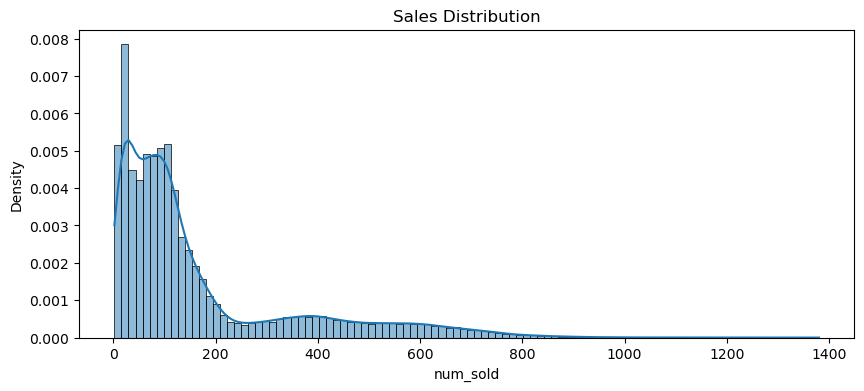

In [9]:
# Sales Distribution
plt.figure(figsize=(10,4))
sns.histplot(df_train["num_sold"],bins=100,kde=True,stat="density");

plt.title("Sales Distribution");

The above plot clarify the distribution of the sales it seems that most sales price between 50 - 150 it counts higher than the others

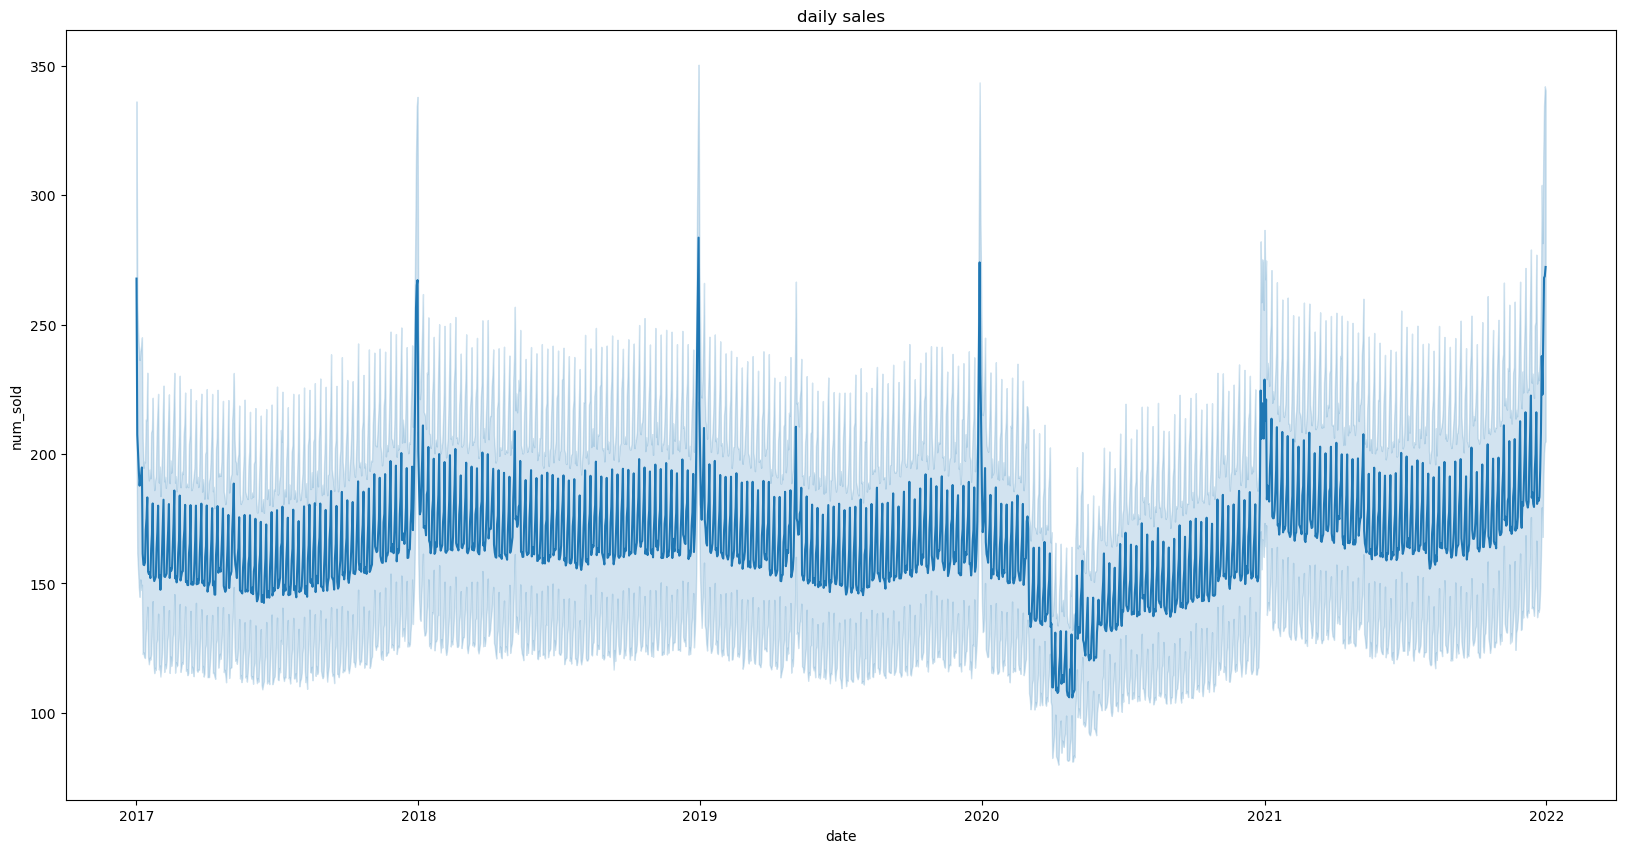

In [10]:
plt.figure(figsize = (20, 10))
sns.lineplot(x=df_train["date"],y=df_train["num_sold"])
plt.title('daily sales')
plt.show();

There is a drop in sales between the years 2020 and 2021 because of the COVID-19 pandemic, and it makes science that the sales are lower than the other.

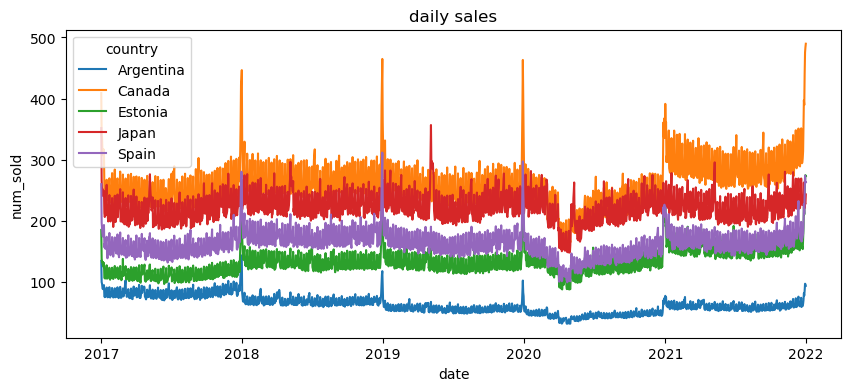

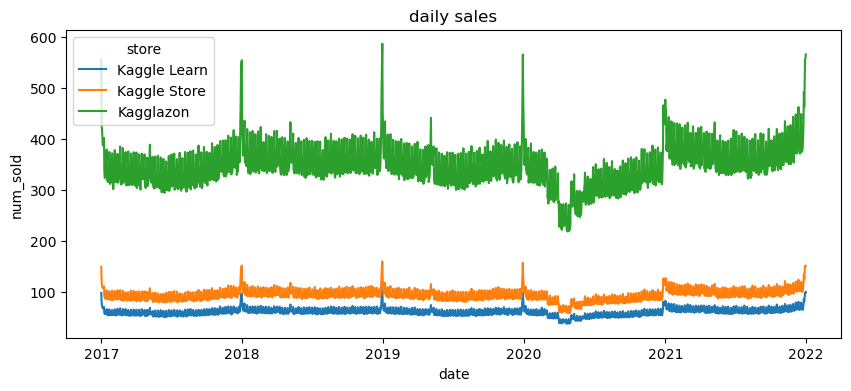

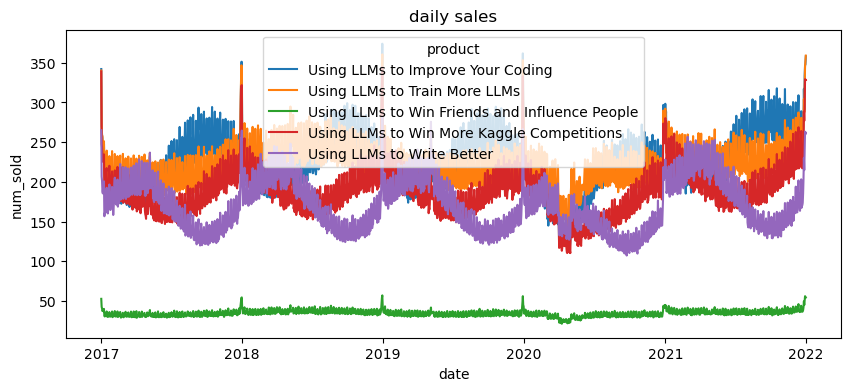

In [11]:
for i in ["country","store","product"]:
    plt.figure(figsize = (10,4))
    sns.lineplot(data=df_train,x="date",y="num_sold",hue=i,errorbar = None)
    plt.title('daily sales')
    plt.show();

The above plots clarify the sales over the years for the product, store, and country.
As we see the highest revenue comes from Canada, Japan, Spain, Estonia, and the last one Aregntina, the plot clarifies that the sales at the end of each year are always higher than the rest of the year, But we should take care of that, in Japan the season of the highest revenue is approximately at the end of April.

### Simple clarification plots

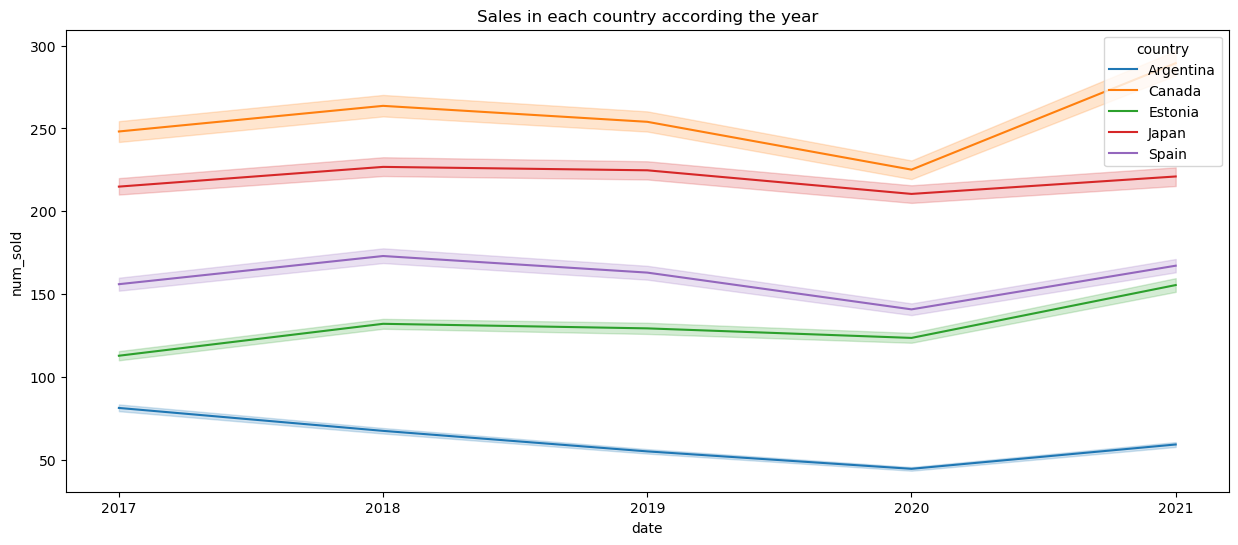

In [12]:
# Explor the sales column
plt.figure(figsize=(15,6))
sns.lineplot(x=df_train["date"].dt.strftime("%Y"),y=df_train["num_sold"],hue=df_train["country"])

plt.title("Sales in each country according the year");

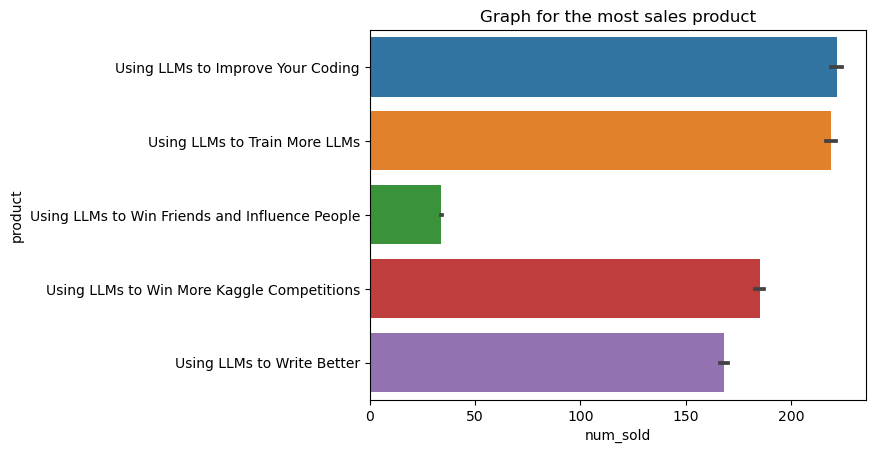

In [13]:
sns.barplot(x=df_train["num_sold"],y=df_train["product"])
plt.title("Graph for the most sales product");

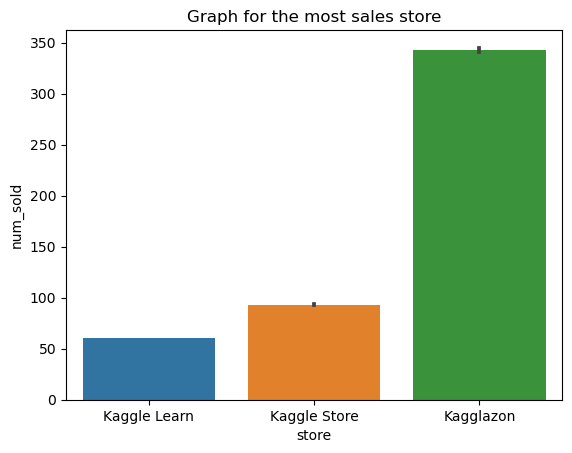

In [14]:
sns.barplot(x=df_train["store"],y=df_train["num_sold"])
plt.title("Graph for the most sales store");

<a id='ML2'></a>
# ML


# Feature Engineering

In [15]:
# Feature Engineering - Creating Features
def get_data(df):
#     df["date"]=pd.to_datetime(df["date"])
    df["month"]=df["date"].dt.strftime("%m").astype(int)
    df["year"]=df["date"].dt.strftime("%Y").astype(int)
    df["day"]=df["date"].dt.strftime("%d").astype(int)
    df['friday'] = df.date.dt.weekday.eq(4).astype(np.uint8)
    df['saturday'] = df.date.dt.weekday.eq(5).astype(np.uint8)
    df['sunday'] = df.date.dt.weekday.eq(6).astype(np.uint8)
    is_year_end=[]
    for i in df['date'].dt.is_year_end:
        if i == True:
            is_year_end.append(1)
        else:
            is_year_end.append(0)
    df['is_year_end']=is_year_end
    df['month_sin'] = np.sin(2*np.pi*df.month/12)
    df['month_cos'] = np.cos(2*np.pi*df.month/12)
    df['day_sin'] = np.sin(2*np.pi*df.day/24)
    df['day_cos'] = np.cos(2*np.pi*df.day/24)
    df['year_sin'] = np.sin(2*np.pi*df.year/365.25)
    df['year_cos'] = np.cos(2*np.pi*df.year/365.25)
#     df['week_sin'] = np.sin(2*np.pi*df.dayofweek/7)
#     df['week_cos'] = np.cos(2*np.pi*df.dayofweek/7)
    le = LabelEncoder()
    cols = ['country', 'store', 'product']
    for col in cols:
        df[col] = le.fit_transform(df[col])
        
#     df=pd.get_dummies(df.drop(["id","date"],axis=1))
    
    def periodic_spline_transformer(period, n_splines=None, degree=3):
        """
        Kaynak: https://scikit-learn.org/stable/auto_examples/applications/plot_cyclical_feature_engineering.html
        """
        
        if n_splines is None:
            n_splines = period
        n_knots = n_splines + 1  # periodic and include_bias is True
        return SplineTransformer(
            degree=degree,
            n_knots=n_knots,
            knots=np.linspace(0, period, n_knots).reshape(n_knots, 1),
            extrapolation="periodic",
            include_bias=True)

    def seasonality_spline_features(hours=np.arange(1,32)):
        hour_df = pd.DataFrame(np.linspace(1, 32, 32).reshape(-1, 1),columns=["day"])
        splines = periodic_spline_transformer(32, n_splines=4).fit_transform(hour_df)
        splines_df = pd.DataFrame(splines,columns=[f"spline_{i}" for i in range(splines.shape[1])])
        splines_df =pd.concat([pd.Series(hours, name='day'), splines_df], axis="columns")

        return splines_df

    df=df.drop(["id","date"],axis=1)
    
    new_df = pd.merge(df, seasonality_spline_features().dropna(axis=0), on='day', how='left')
    
    return new_df

In [16]:
# creat x and y
x=get_data(df_train).drop(["num_sold"],axis=1)
y=get_data(df_train)["num_sold"]

<a id='ML3'></a>
## Model Selection


<u> <b>SMAPE Equation:

$${SMAPE} = \frac{100}{n} \sum_{t=1}^n \frac{\left|F_t-A_t\right|}{(|A_t|+|F_t|)/2}$$

In [17]:
# use CatBoostRegressor and improve it by adding hyperparameters
x_tr,x_val,y_tr,y_val = train_test_split(x, y , test_size = 0.1, random_state=42)

tscv = TimeSeriesSplit(n_splits=5)

for fold,(train_index, test_index) in enumerate(tscv.split(x_tr,y_tr)):
    x_train, x_test = x_tr.iloc[train_index], x.iloc[test_index]
    y_train, y_test = y_tr.iloc[train_index], y.iloc[test_index]
    print(f"Fold {fold+1}")
    print(f"Shape{x_train.shape}")
#     final_model=RandomForestRegressor()
    final_model=CatBoostRegressor(learning_rate=.1,max_depth=7,verbose=False)
    final_model.fit(x_train,y_train)
    pred_y=final_model.predict(x_test)
    SMAPE_score= 1/len(y_test) * np.sum(2 * np.abs(pred_y - y_test) / (np.abs(pred_y) + np.abs(y_test)) * 100)
    print("CatBoostRegressor SMAPE Score",SMAPE_score)

Fold 1
Shape(20545, 20)
CatBoostRegressor SMAPE Score 6.833714239315971
Fold 2
Shape(41087, 20)
CatBoostRegressor SMAPE Score 6.128042450407927
Fold 3
Shape(61629, 20)
CatBoostRegressor SMAPE Score 6.403341573441935
Fold 4
Shape(82171, 20)
CatBoostRegressor SMAPE Score 9.20580525594004
Fold 5
Shape(102713, 20)
CatBoostRegressor SMAPE Score 6.734600768381682


<a id='ML6'></a>

## Model Selected

In [18]:
# # Define conditions and corresponding multipliers

df_test["num_sold"]=final_model.predict(get_data(df_test))

conditions = [
    df_test['country'] == 0,
    df_test['country'] == 1,
    df_test['country'] == 2,
    df_test['country'] == 3,
    df_test['country'] == 4
    # Add more conditions if needed for other countries
]

multipliers = [2.4, .8, 1.8 , 0.95 , 1.25]  # Corresponding multipliers for the conditions above

# Apply the conditions and multipliers using np.select
df_test['num_sold'] = np.select(conditions, multipliers, default=1.0) * df_test['num_sold']

pd.DataFrame(df_test)
# df_test

,id,date,country,store,product,month,year,day,friday,saturday,sunday,is_year_end,month_sin,month_cos,day_sin,day_cos,year_sin,year_cos,num_sold
0,136950,2017-01-01,0,1,0,1,2017,1,0,0,1,0,5.000000e-01,0.866025,0.258819,0.965926,-0.139315,-0.990248,159.951324
1,136951,2017-01-01,0,1,1,1,2017,1,0,0,1,0,5.000000e-01,0.866025,0.258819,0.965926,-0.139315,-0.990248,158.672909
2,136952,2017-01-01,0,1,2,1,2017,1,0,0,1,0,5.000000e-01,0.866025,0.258819,0.965926,-0.139315,-0.990248,22.390574
3,136953,2017-01-01,0,1,3,1,2017,1,0,0,1,0,5.000000e-01,0.866025,0.258819,0.965926,-0.139315,-0.990248,152.000510
4,136954,2017-01-01,0,1,4,1,2017,1,0,0,1,0,5.000000e-01,0.866025,0.258819,0.965926,-0.139315,-0.990248,126.302164
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27370,164320,2017-12-31,4,0,0,12,2017,31,0,0,1,1,-2.449294e-16,1.000000,0.965926,-0.258819,-0.139315,-0.990248,883.133119
27371,164321,2017-12-31,4,0,1,12,2017,31,0,0,1,1,-2.449294e-16,1.000000,0.965926,-0.258819,-0.139315,-0.990248,877.035727
27372,164322,2017-12-31,4,0,2,12,2017,31,0,0,1,1,-2.449294e-16,1.000000,0.965926,-0.258819,-0.139315,-0.990248,161.629744
27373,164323,2017-12-31,4,0,3,12,2017,31,0,0,1,1,-2.449294e-16,1.000000,0.965926,-0.258819,-0.139315,-0.990248,828.482107


In [19]:
pred=pd.DataFrame({'id':id_df_test,'num_sold':df_test["num_sold"]})
pred.head()

,id,num_sold
0,136950,159.951324
1,136951,158.672909
2,136952,22.390574
3,136953,152.000510
4,136954,126.302164


In [20]:
pred.to_csv("submission.csv",index=False)

In [21]:
!head submission.csv

id,num_sold
136950,159.95132401876245
136951,158.6729085557467
136952,22.390574328872663
136953,152.0005102359132
136954,126.30216352214065
136955,222.89429484229547
136956,223.02030952429405
136957,43.04969976797702
136958,216.308418117437
